In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import torch
import torch.nn as nn
import numpy as np


import torch.utils.data as data
from data import TCGAData, GeneData

from aug import MixupNomralAugmentor
from data import TCGAData, GeneData
from model import TCGAPretrainModel
from train import predict, train

from loss import TripletLoss, TripletCosineLoss, CEWithNaNLabelsLoss, MSEWithNaNLabelsLoss
from saver import SaveBestModel
from plot import plot_embed_with_label



def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    return dfd
    
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)
df_cancer = tcga_label[['cancer_type']]

df_tmb = mutation[['tmb']]
df_msi = mutation[['msi']]
df_cnv= mutation[['cnv']]
df_ctc = tcga_label[['cancer_type']]

df_msi = onehot(df_msi.msi)
df_ctc = onehot(df_ctc.cancer_type)
df_rps = onehot(tcga_label['treatment_outcome'])
df_ost = np.log10(tcga_label[['os_time']]+1)
df_oss = onehot(tcga_label.os_status)

df_pft = np.log10(tcga_label[['pfi_time']]+1)
df_pfs = onehot(tcga_label.pfi_status)





tasks = {'msi': df_msi, 
         'tmb': df_tmb, 
         'cnv':df_cnv, 
         'ctc':df_ctc, 
         'rps':df_rps, 
         'ost':df_ost,
         'oss':df_oss,
         'pft':df_pft,
         'pfs':df_pfs}

tasks = {
         'tmb': df_tmb, }

tasks_type_map = {'msi': 'c', 'tmb': 'r', 
                  'cnv':'r', 'ctc':'c', 
                  'rps':'c', 'ost':'r', 
                  'oss':'c', 'pft':'r', 'pfs':'c'}


## parameters
device='cuda'
lr = 1e-6
weight_decay = 1e-4
epochs = 500
batch_size = 64
embed_dim=32
triplet_margin=1.

task_loss_weight = 0.
task_dense_layer = [16]
task_batch_norms = True

encoder='transformer'
transformer_dim = 256
transformer_num_layers = 4

#encoder= 'mlp'
mlp_dense_layers = [512, 256, 128]


for sl_task,df_task  in tasks.items():
    task_type = tasks_type_map[sl_task]
    save_dir = './PretrainTCGA_%s_%s' % (encoder, sl_task)

    ### setup ###
    augmentor = MixupNomralAugmentor(df_tpm_normal, df_tpm_normal.columns, beta=0.7)
    train_tcga = TCGAData(df_tpm, df_task, augmentor)
    train_loader = data.DataLoader(train_tcga, batch_size=batch_size, shuffle=True,
                                    drop_last=True, pin_memory=True, num_workers=4)
    
    input_dim = len(train_tcga.feature_name)
    task_dim = train_tcga.y.shape[1]
    model = TCGAPretrainModel(input_dim, task_dim, task_type, embed_dim, 
                              encoder = encoder, #
                              mlp_dense_layers = mlp_dense_layers, 
                              transformer_dim = transformer_dim,
                              transformer_num_layers = transformer_num_layers,
                              task_dense_layer = task_dense_layer, 
                              task_batch_norms = task_batch_norms) 
    model = model.to(device)
    
    triplet_loss = torch.jit.script(TripletLoss(margin=triplet_margin))
    ce_loss = torch.jit.script(CEWithNaNLabelsLoss())
    mse_loss = torch.jit.script(MSEWithNaNLabelsLoss())
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    saver = SaveBestModel(save_dir = save_dir, save_name = 'tcga_best_model.pth')
    ssl_loss = triplet_loss
    if task_type == 'c':
        tsk_loss = ce_loss
    else:
        tsk_loss = mse_loss

    ### training ###
    performace = []
    for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
        train_total_loss, train_ssl_loss, train_tsk_loss = train(train_loader, model, optimizer, 
                                                                 ssl_loss, tsk_loss, device, 
                                                                 alpha = task_loss_weight)
        saver(train_total_loss, epoch, model, optimizer)
        performace.append([epoch, train_total_loss, train_ssl_loss, train_tsk_loss])
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, train_total_loss))
    saver.save()


    ## plot loss
    df = pd.DataFrame(performace, columns = ['epochs', 'total_loss', 'ssl_loss', 'tsk_loss']).set_index('epochs')
    v = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    fig, ax = plt.subplots(figsize=(7,5))
    df.plot(ax = ax)
    fig.savefig(os.path.join(save_dir, 'tcga_train_loss.png'), bbox_inches='tight')
    df.to_pickle(os.path.join(save_dir, 'tcga_train_loss.pkl'))

    ### make prediction & plot on TCGA
    model = TCGAPretrainModel(**saver.inMemorySave['model_args']) #transformer_dim = 128, transformer_num_layers = 2
    model.load_state_dict(saver.inMemorySave['model_state_dict'])
    dfe, dfp = predict(df_tpm, model,  device='cpu')
    dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
    msi = tcga_label[['msi']]
    cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')
    
    l1 = tcga_label[['race', 'vital_status', 'treatment_outcome']].fillna('NaN')
    l2 = np.log10(tcga_label[['pfi_time', 'os_time']]+1)
    l3 = tcga_label[['gender', 'age',]]


    dfd = dfe.join(dfc).join(df_tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)
    
    label_col = ['cancer_type', 'tmb', 'cnv', 'msi','race', 'vital_status', 
                 'treatment_outcome','pfi_time', 'gender', 'age', 'os_time']
    label_type = ['c', 'r', 'r', 'c',  'c', 'c', 'c',  'r',  'c', 'r', 'r',]
    figs = plot_embed_with_label(dfd, n_neighbors=15, spread=5,
                                 label_col = label_col,  
                                 label_type = label_type, figsize=(5,5))
    
    for fig, name in zip(figs, label_col):
        fig.savefig(os.path.join(save_dir, 'tcga_%s.png' % name), bbox_inches='tight', )

    ### make prediction & plot on ITRP
    itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
    itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
    itrp_meta['response_label'] = itrp_meta['Freeman_response']
    itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']
    itrp_y = itrp_meta[['response_label']]
    itrp_c = itrp_meta[['cohort']]
    itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T
    
    itrp_dfe, itrp_dfp = predict(itrp_x, model,  device='cpu')

    label_col = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
    label_type = ['c', 'c', 'c', 'c', 'r']
    dfd = itrp_dfe.join(itrp_meta[label_col])
    figs = plot_embed_with_label(dfd, n_neighbors=15,
                                spread=5,
                                s=20,
                                 label_col = label_col,  
                                 label_type = label_type, figsize=(5,5))
    for fig, name in zip(figs, label_col):
        fig.savefig(os.path.join(save_dir, 'itrp_%s.png' % name), bbox_inches='tight', )

Epochs:   0%|          | 1/500 [00:06<50:11,  6.04s/it]

Epoch: 1/500 - Loss: 1.0386


Epochs:   0%|          | 2/500 [00:12<54:22,  6.55s/it]

Epoch: 2/500 - Loss: 1.0052


Epochs:   1%|          | 3/500 [00:19<53:44,  6.49s/it]

Epoch: 3/500 - Loss: 0.9989


Epochs:   1%|          | 4/500 [00:26<55:08,  6.67s/it]

Epoch: 4/500 - Loss: 0.9585


Epochs:   1%|1         | 5/500 [00:33<55:26,  6.72s/it]

Epoch: 5/500 - Loss: 0.5981


Epochs:   1%|1         | 6/500 [00:39<54:35,  6.63s/it]

Epoch: 6/500 - Loss: 0.5606


Epochs:   1%|1         | 7/500 [00:45<52:38,  6.41s/it]

Epoch: 7/500 - Loss: 0.5365


Epochs:   2%|1         | 8/500 [00:51<51:39,  6.30s/it]

Epoch: 8/500 - Loss: 0.5237


Epochs:   2%|1         | 9/500 [00:57<51:22,  6.28s/it]

Epoch: 9/500 - Loss: 0.5249


Epochs:   2%|2         | 10/500 [01:03<50:57,  6.24s/it]

Epoch: 10/500 - Loss: 0.5124


Epochs:   2%|2         | 11/500 [01:10<52:21,  6.42s/it]

Epoch: 11/500 - Loss: 0.5081


Epochs:   2%|2         | 12/500 [01:17<52:03,  6.40s/it]

Epoch: 12/500 - Loss: 0.4863


Epochs:   3%|2         | 13/500 [01:23<52:02,  6.41s/it]

Epoch: 13/500 - Loss: 0.4877


Epochs:   3%|2         | 14/500 [01:29<51:03,  6.30s/it]

Epoch: 14/500 - Loss: 0.4651


Epochs:   3%|3         | 15/500 [01:35<50:13,  6.21s/it]

Epoch: 15/500 - Loss: 0.4673


Epochs:   3%|3         | 16/500 [01:42<52:05,  6.46s/it]

Epoch: 16/500 - Loss: 0.4557


Epochs:   3%|3         | 17/500 [01:49<53:06,  6.60s/it]

Epoch: 17/500 - Loss: 0.4457


Epochs:   4%|3         | 18/500 [01:56<53:28,  6.66s/it]

Epoch: 18/500 - Loss: 0.4296


Epochs:   4%|3         | 19/500 [02:02<52:14,  6.52s/it]

Epoch: 19/500 - Loss: 0.4235


Epochs:   4%|4         | 20/500 [02:08<50:55,  6.37s/it]

Epoch: 20/500 - Loss: 0.4010


Epochs:   4%|4         | 21/500 [02:15<52:26,  6.57s/it]

Epoch: 21/500 - Loss: 0.3864


Epochs:   4%|4         | 22/500 [02:21<51:14,  6.43s/it]

Epoch: 22/500 - Loss: 0.3723


Epochs:   5%|4         | 23/500 [02:28<51:21,  6.46s/it]

Epoch: 23/500 - Loss: 0.3540


Epochs:   5%|4         | 24/500 [02:34<50:20,  6.35s/it]

Epoch: 24/500 - Loss: 0.3499


Epochs:   5%|5         | 25/500 [02:41<51:57,  6.56s/it]

Epoch: 25/500 - Loss: 0.3489


Epochs:   5%|5         | 26/500 [02:47<50:56,  6.45s/it]

Epoch: 26/500 - Loss: 0.3294


Epochs:   5%|5         | 27/500 [02:54<51:00,  6.47s/it]

Epoch: 27/500 - Loss: 0.3099


Epochs:   6%|5         | 28/500 [03:00<51:28,  6.54s/it]

Epoch: 28/500 - Loss: 0.2932


Epochs:   6%|5         | 29/500 [03:06<50:23,  6.42s/it]

Epoch: 29/500 - Loss: 0.2810


Epochs:   6%|6         | 30/500 [03:13<50:19,  6.43s/it]

Epoch: 30/500 - Loss: 0.3003


Epochs:   6%|6         | 31/500 [03:20<50:59,  6.52s/it]

Epoch: 31/500 - Loss: 0.2957


Epochs:   6%|6         | 32/500 [03:27<52:15,  6.70s/it]

Epoch: 32/500 - Loss: 0.2885


Epochs:   7%|6         | 33/500 [03:33<50:59,  6.55s/it]

Epoch: 33/500 - Loss: 0.2505


Epochs:   7%|6         | 34/500 [03:39<50:03,  6.45s/it]

Epoch: 34/500 - Loss: 0.2541


Epochs:   7%|7         | 35/500 [03:46<50:23,  6.50s/it]

Epoch: 35/500 - Loss: 0.2775


Epochs:   7%|7         | 36/500 [03:53<51:47,  6.70s/it]

Epoch: 36/500 - Loss: 0.2718


Epochs:   7%|7         | 37/500 [04:00<52:32,  6.81s/it]

Epoch: 37/500 - Loss: 0.2538


Epochs:   8%|7         | 38/500 [04:07<52:19,  6.80s/it]

Epoch: 38/500 - Loss: 0.2899


Epochs:   8%|7         | 39/500 [04:13<50:33,  6.58s/it]

Epoch: 39/500 - Loss: 0.2322


Epochs:   8%|8         | 40/500 [04:19<50:07,  6.54s/it]

Epoch: 40/500 - Loss: 0.2219


Epochs:   8%|8         | 41/500 [04:26<51:17,  6.70s/it]

Epoch: 41/500 - Loss: 0.2304


Epochs:   8%|8         | 42/500 [04:33<50:55,  6.67s/it]

Epoch: 42/500 - Loss: 0.1978


Epochs:   9%|8         | 43/500 [04:40<52:15,  6.86s/it]

Epoch: 43/500 - Loss: 0.2134


Epochs:   9%|8         | 44/500 [04:47<51:02,  6.72s/it]

Epoch: 44/500 - Loss: 0.2276


Epochs:   9%|9         | 45/500 [04:54<51:20,  6.77s/it]

Epoch: 45/500 - Loss: 0.2052


Epochs:   9%|9         | 46/500 [05:00<50:53,  6.73s/it]

Epoch: 46/500 - Loss: 0.1954


Epochs:   9%|9         | 47/500 [05:06<49:21,  6.54s/it]

Epoch: 47/500 - Loss: 0.2201


Epochs:  10%|9         | 48/500 [05:13<49:28,  6.57s/it]

Epoch: 48/500 - Loss: 0.2167


Epochs:  10%|9         | 49/500 [05:19<48:52,  6.50s/it]

Epoch: 49/500 - Loss: 0.1930


Epochs:  10%|#         | 50/500 [05:26<49:07,  6.55s/it]

Epoch: 50/500 - Loss: 0.2159


Epochs:  10%|#         | 51/500 [05:33<49:05,  6.56s/it]

Epoch: 51/500 - Loss: 0.2009


Epochs:  10%|#         | 52/500 [05:40<50:51,  6.81s/it]

Epoch: 52/500 - Loss: 0.1937


Epochs:  11%|#         | 53/500 [05:46<49:40,  6.67s/it]

Epoch: 53/500 - Loss: 0.1913


Epochs:  11%|#         | 54/500 [05:52<48:10,  6.48s/it]

Epoch: 54/500 - Loss: 0.2021


Epochs:  11%|#1        | 55/500 [05:59<48:04,  6.48s/it]

Epoch: 55/500 - Loss: 0.1594


Epochs:  11%|#1        | 56/500 [06:06<49:05,  6.63s/it]

Epoch: 56/500 - Loss: 0.1891


Epochs:  11%|#1        | 57/500 [06:12<49:03,  6.64s/it]

Epoch: 57/500 - Loss: 0.1789


Epochs:  12%|#1        | 58/500 [06:18<47:33,  6.46s/it]

Epoch: 58/500 - Loss: 0.1944


Epochs:  12%|#1        | 59/500 [06:24<46:22,  6.31s/it]

Epoch: 59/500 - Loss: 0.1816


Epochs:  12%|#2        | 60/500 [06:30<45:35,  6.22s/it]

Epoch: 60/500 - Loss: 0.1613


Epochs:  12%|#2        | 61/500 [06:37<46:37,  6.37s/it]

Epoch: 61/500 - Loss: 0.1506


Epochs:  12%|#2        | 62/500 [06:44<46:24,  6.36s/it]

Epoch: 62/500 - Loss: 0.1571


Epochs:  13%|#2        | 63/500 [06:50<46:44,  6.42s/it]

Epoch: 63/500 - Loss: 0.1691


Epochs:  13%|#2        | 64/500 [06:56<46:19,  6.37s/it]

Epoch: 64/500 - Loss: 0.1604


Epochs:  13%|#3        | 65/500 [07:02<45:11,  6.23s/it]

Epoch: 65/500 - Loss: 0.1486


Epochs:  13%|#3        | 66/500 [07:08<45:00,  6.22s/it]

Epoch: 66/500 - Loss: 0.1566


Epochs:  13%|#3        | 67/500 [07:15<45:49,  6.35s/it]

Epoch: 67/500 - Loss: 0.1693


Epochs:  14%|#3        | 68/500 [07:21<45:38,  6.34s/it]

Epoch: 68/500 - Loss: 0.1317


Epochs:  14%|#3        | 69/500 [07:28<45:23,  6.32s/it]

Epoch: 69/500 - Loss: 0.1403


Epochs:  14%|#4        | 70/500 [07:34<45:10,  6.30s/it]

Epoch: 70/500 - Loss: 0.1293


Epochs:  14%|#4        | 71/500 [07:40<45:26,  6.36s/it]

Epoch: 71/500 - Loss: 0.1564


Epochs:  14%|#4        | 72/500 [07:47<45:10,  6.33s/it]

Epoch: 72/500 - Loss: 0.1175


Epochs:  15%|#4        | 73/500 [07:53<45:28,  6.39s/it]

Epoch: 73/500 - Loss: 0.1430


Epochs:  15%|#4        | 74/500 [08:00<45:53,  6.46s/it]

Epoch: 74/500 - Loss: 0.1187


Epochs:  15%|#5        | 75/500 [08:06<44:46,  6.32s/it]

Epoch: 75/500 - Loss: 0.1499


Epochs:  15%|#5        | 76/500 [08:12<44:51,  6.35s/it]

Epoch: 76/500 - Loss: 0.1307


Epochs:  15%|#5        | 77/500 [08:19<44:53,  6.37s/it]

Epoch: 77/500 - Loss: 0.1603


Epochs:  16%|#5        | 78/500 [08:26<47:17,  6.72s/it]

Epoch: 78/500 - Loss: 0.1291


Epochs:  16%|#5        | 79/500 [08:32<44:25,  6.33s/it]

Epoch: 79/500 - Loss: 0.1365


Epochs:  16%|#6        | 80/500 [08:39<45:51,  6.55s/it]

Epoch: 80/500 - Loss: 0.1505


Epochs:  16%|#6        | 81/500 [08:45<44:49,  6.42s/it]

Epoch: 81/500 - Loss: 0.1372


Epochs:  16%|#6        | 82/500 [08:52<46:03,  6.61s/it]

Epoch: 82/500 - Loss: 0.1334


Epochs:  17%|#6        | 83/500 [08:57<43:36,  6.28s/it]

Epoch: 83/500 - Loss: 0.1089


Epochs:  17%|#6        | 84/500 [09:04<45:15,  6.53s/it]

Epoch: 84/500 - Loss: 0.1361


Epochs:  17%|#7        | 85/500 [09:12<46:25,  6.71s/it]

Epoch: 85/500 - Loss: 0.1081


Epochs:  17%|#7        | 86/500 [09:18<46:05,  6.68s/it]

Epoch: 86/500 - Loss: 0.1580


Epochs:  17%|#7        | 87/500 [09:24<43:45,  6.36s/it]

Epoch: 87/500 - Loss: 0.1018


Epochs:  18%|#7        | 88/500 [09:30<44:10,  6.43s/it]

Epoch: 88/500 - Loss: 0.1247


Epochs:  18%|#7        | 89/500 [09:38<45:40,  6.67s/it]

Epoch: 89/500 - Loss: 0.0912


Epochs:  18%|#8        | 90/500 [09:45<46:02,  6.74s/it]

Epoch: 90/500 - Loss: 0.1028


Epochs:  18%|#8        | 91/500 [09:52<47:40,  6.99s/it]

Epoch: 91/500 - Loss: 0.1040


Epochs:  18%|#8        | 92/500 [09:59<47:19,  6.96s/it]

Epoch: 92/500 - Loss: 0.1387


Epochs:  19%|#8        | 93/500 [10:07<49:54,  7.36s/it]

Epoch: 93/500 - Loss: 0.0983


Epochs:  19%|#8        | 94/500 [10:14<48:33,  7.18s/it]

Epoch: 94/500 - Loss: 0.1032


Epochs:  19%|#9        | 95/500 [10:20<45:46,  6.78s/it]

Epoch: 95/500 - Loss: 0.1235


Epochs:  19%|#9        | 96/500 [10:26<44:14,  6.57s/it]

Epoch: 96/500 - Loss: 0.1094


Epochs:  19%|#9        | 97/500 [10:33<45:48,  6.82s/it]

Epoch: 97/500 - Loss: 0.0978


Epochs:  20%|#9        | 98/500 [10:39<43:35,  6.51s/it]

Epoch: 98/500 - Loss: 0.0899


Epochs:  20%|#9        | 99/500 [10:45<41:06,  6.15s/it]

Epoch: 99/500 - Loss: 0.1105


Epochs:  20%|##        | 100/500 [10:51<42:37,  6.39s/it]

Epoch: 100/500 - Loss: 0.1044


Epochs:  20%|##        | 101/500 [10:58<43:24,  6.53s/it]

Epoch: 101/500 - Loss: 0.1122


Epochs:  20%|##        | 102/500 [11:07<47:23,  7.14s/it]

Epoch: 102/500 - Loss: 0.1019


Epochs:  21%|##        | 103/500 [11:13<44:23,  6.71s/it]

Epoch: 103/500 - Loss: 0.1123


Epochs:  21%|##        | 104/500 [11:21<47:03,  7.13s/it]

Epoch: 104/500 - Loss: 0.0972


Epochs:  21%|##1       | 105/500 [11:28<47:37,  7.23s/it]

Epoch: 105/500 - Loss: 0.1008


Epochs:  21%|##1       | 106/500 [11:36<48:49,  7.44s/it]

Epoch: 106/500 - Loss: 0.1328


Epochs:  21%|##1       | 107/500 [11:42<46:40,  7.13s/it]

Epoch: 107/500 - Loss: 0.1244


Epochs:  22%|##1       | 108/500 [11:50<47:05,  7.21s/it]

Epoch: 108/500 - Loss: 0.1100


Epochs:  22%|##1       | 109/500 [11:57<46:12,  7.09s/it]

Epoch: 109/500 - Loss: 0.0864


Epochs:  22%|##2       | 110/500 [12:03<44:19,  6.82s/it]

Epoch: 110/500 - Loss: 0.0980


Epochs:  22%|##2       | 111/500 [12:10<44:18,  6.83s/it]

Epoch: 111/500 - Loss: 0.1170


Epochs:  22%|##2       | 112/500 [12:17<45:47,  7.08s/it]

Epoch: 112/500 - Loss: 0.1158


Epochs:  23%|##2       | 113/500 [12:24<44:16,  6.86s/it]

Epoch: 113/500 - Loss: 0.0911


Epochs:  23%|##2       | 114/500 [12:30<42:36,  6.62s/it]

Epoch: 114/500 - Loss: 0.0888


Epochs:  23%|##3       | 115/500 [12:36<41:10,  6.42s/it]

Epoch: 115/500 - Loss: 0.0964


Epochs:  23%|##3       | 116/500 [12:43<41:48,  6.53s/it]

Epoch: 116/500 - Loss: 0.1042


Epochs:  23%|##3       | 117/500 [12:51<44:34,  6.98s/it]

Epoch: 117/500 - Loss: 0.0888


Epochs:  24%|##3       | 118/500 [12:56<41:24,  6.51s/it]

Epoch: 118/500 - Loss: 0.1088


Epochs:  24%|##3       | 119/500 [13:02<40:08,  6.32s/it]

Epoch: 119/500 - Loss: 0.1256


Epochs:  24%|##4       | 120/500 [13:09<41:13,  6.51s/it]

Epoch: 120/500 - Loss: 0.1055


Epochs:  24%|##4       | 121/500 [13:15<39:51,  6.31s/it]

Epoch: 121/500 - Loss: 0.0996


Epochs:  24%|##4       | 122/500 [13:21<38:52,  6.17s/it]

Epoch: 122/500 - Loss: 0.0862


Epochs:  25%|##4       | 123/500 [13:26<38:21,  6.11s/it]

Epoch: 123/500 - Loss: 0.0867


Epochs:  25%|##4       | 124/500 [13:32<36:31,  5.83s/it]

Epoch: 124/500 - Loss: 0.0894


Epochs:  25%|##5       | 125/500 [13:39<38:56,  6.23s/it]

Epoch: 125/500 - Loss: 0.0757


Epochs:  25%|##5       | 126/500 [13:46<39:47,  6.38s/it]

Epoch: 126/500 - Loss: 0.0807


Epochs:  25%|##5       | 127/500 [13:53<41:52,  6.74s/it]

Epoch: 127/500 - Loss: 0.0941


Epochs:  26%|##5       | 128/500 [14:01<43:43,  7.05s/it]

Epoch: 128/500 - Loss: 0.0802


Epochs:  26%|##5       | 129/500 [14:07<41:11,  6.66s/it]

Epoch: 129/500 - Loss: 0.1038


Epochs:  26%|##6       | 130/500 [14:13<41:18,  6.70s/it]

Epoch: 130/500 - Loss: 0.0838


Epochs:  26%|##6       | 131/500 [14:18<38:00,  6.18s/it]

Epoch: 131/500 - Loss: 0.0661


Epochs:  26%|##6       | 132/500 [14:25<37:47,  6.16s/it]

Epoch: 132/500 - Loss: 0.1059


Epochs:  27%|##6       | 133/500 [14:32<40:03,  6.55s/it]

Epoch: 133/500 - Loss: 0.0983


Epochs:  27%|##6       | 134/500 [14:40<42:03,  6.89s/it]

Epoch: 134/500 - Loss: 0.0956


Epochs:  27%|##7       | 135/500 [14:46<41:28,  6.82s/it]

Epoch: 135/500 - Loss: 0.0727


Epochs:  27%|##7       | 136/500 [14:52<38:34,  6.36s/it]

Epoch: 136/500 - Loss: 0.0694


Epochs:  27%|##7       | 137/500 [14:57<36:42,  6.07s/it]

Epoch: 137/500 - Loss: 0.0697


Epochs:  28%|##7       | 138/500 [15:03<36:38,  6.07s/it]

Epoch: 138/500 - Loss: 0.0816


Epochs:  28%|##7       | 139/500 [15:09<36:31,  6.07s/it]

Epoch: 139/500 - Loss: 0.0500


Epochs:  28%|##8       | 140/500 [15:15<36:41,  6.11s/it]

Epoch: 140/500 - Loss: 0.0799


Epochs:  28%|##8       | 141/500 [15:21<35:58,  6.01s/it]

Epoch: 141/500 - Loss: 0.0934


Epochs:  28%|##8       | 142/500 [15:27<35:53,  6.02s/it]

Epoch: 142/500 - Loss: 0.1041


Epochs:  29%|##8       | 143/500 [15:35<39:17,  6.60s/it]

Epoch: 143/500 - Loss: 0.0767


Epochs:  29%|##8       | 144/500 [15:42<40:08,  6.76s/it]

Epoch: 144/500 - Loss: 0.0798


Epochs:  29%|##9       | 145/500 [15:48<37:22,  6.32s/it]

Epoch: 145/500 - Loss: 0.0875


Epochs:  29%|##9       | 146/500 [15:53<36:23,  6.17s/it]

Epoch: 146/500 - Loss: 0.0893


Epochs:  29%|##9       | 147/500 [16:01<39:03,  6.64s/it]

Epoch: 147/500 - Loss: 0.0724


Epochs:  30%|##9       | 148/500 [16:07<36:52,  6.29s/it]

Epoch: 148/500 - Loss: 0.0624


Epochs:  30%|##9       | 149/500 [16:12<34:55,  5.97s/it]

Epoch: 149/500 - Loss: 0.0597


Epochs:  30%|###       | 150/500 [16:17<34:10,  5.86s/it]

Epoch: 150/500 - Loss: 0.0643


Epochs:  30%|###       | 151/500 [16:23<34:09,  5.87s/it]

Epoch: 151/500 - Loss: 0.0759


Epochs:  30%|###       | 152/500 [16:30<35:35,  6.14s/it]

Epoch: 152/500 - Loss: 0.0802


Epochs:  31%|###       | 153/500 [16:36<35:15,  6.10s/it]

Epoch: 153/500 - Loss: 0.0622


Epochs:  31%|###       | 154/500 [16:43<36:28,  6.33s/it]

Epoch: 154/500 - Loss: 0.0875


Epochs:  31%|###1      | 155/500 [16:48<34:43,  6.04s/it]

Epoch: 155/500 - Loss: 0.0951


Epochs:  31%|###1      | 156/500 [16:54<33:17,  5.81s/it]

Epoch: 156/500 - Loss: 0.0729


Epochs:  31%|###1      | 157/500 [16:59<33:05,  5.79s/it]

Epoch: 157/500 - Loss: 0.0880


Epochs:  32%|###1      | 158/500 [17:06<34:20,  6.02s/it]

Epoch: 158/500 - Loss: 0.0647


Epochs:  32%|###1      | 159/500 [17:12<33:41,  5.93s/it]

Epoch: 159/500 - Loss: 0.0655


Epochs:  32%|###2      | 160/500 [17:17<33:26,  5.90s/it]

Epoch: 160/500 - Loss: 0.0830


Epochs:  32%|###2      | 161/500 [17:25<37:00,  6.55s/it]

Epoch: 161/500 - Loss: 0.0897


Epochs:  32%|###2      | 162/500 [17:33<38:14,  6.79s/it]

Epoch: 162/500 - Loss: 0.0882


Epochs:  33%|###2      | 163/500 [17:39<36:33,  6.51s/it]

Epoch: 163/500 - Loss: 0.0912


Epochs:  33%|###2      | 164/500 [17:47<38:39,  6.90s/it]

Epoch: 164/500 - Loss: 0.0742


Epochs:  33%|###3      | 165/500 [17:52<36:45,  6.58s/it]

Epoch: 165/500 - Loss: 0.0593


Epochs:  33%|###3      | 166/500 [17:58<34:59,  6.29s/it]

Epoch: 166/500 - Loss: 0.0577


Epochs:  33%|###3      | 167/500 [18:04<34:21,  6.19s/it]

Epoch: 167/500 - Loss: 0.0598


Epochs:  34%|###3      | 168/500 [18:09<33:10,  6.00s/it]

Epoch: 168/500 - Loss: 0.0568


Epochs:  34%|###3      | 169/500 [18:15<32:38,  5.92s/it]

Epoch: 169/500 - Loss: 0.0810


Epochs:  34%|###4      | 170/500 [18:22<33:35,  6.11s/it]

Epoch: 170/500 - Loss: 0.0890


Epochs:  34%|###4      | 171/500 [18:28<33:50,  6.17s/it]

Epoch: 171/500 - Loss: 0.0604


Epochs:  34%|###4      | 172/500 [18:36<36:43,  6.72s/it]

Epoch: 172/500 - Loss: 0.0912


Epochs:  35%|###4      | 173/500 [18:43<36:18,  6.66s/it]

Epoch: 173/500 - Loss: 0.0853


Epochs:  35%|###4      | 174/500 [18:50<37:54,  6.98s/it]

Epoch: 174/500 - Loss: 0.0598


Epochs:  35%|###5      | 175/500 [18:56<35:18,  6.52s/it]

Epoch: 175/500 - Loss: 0.0541


Epochs:  35%|###5      | 176/500 [19:02<35:02,  6.49s/it]

Epoch: 176/500 - Loss: 0.0825


Epochs:  35%|###5      | 177/500 [19:10<36:33,  6.79s/it]

Epoch: 177/500 - Loss: 0.0701


Epochs:  36%|###5      | 178/500 [19:15<34:21,  6.40s/it]

Epoch: 178/500 - Loss: 0.0613


Epochs:  36%|###5      | 179/500 [19:22<34:46,  6.50s/it]

Epoch: 179/500 - Loss: 0.0730


Epochs:  36%|###6      | 180/500 [19:28<34:36,  6.49s/it]

Epoch: 180/500 - Loss: 0.0897


Epochs:  36%|###6      | 181/500 [19:34<33:07,  6.23s/it]

Epoch: 181/500 - Loss: 0.1099


Epochs:  36%|###6      | 182/500 [19:42<35:22,  6.67s/it]

Epoch: 182/500 - Loss: 0.0725


Epochs:  37%|###6      | 183/500 [19:47<33:20,  6.31s/it]

Epoch: 183/500 - Loss: 0.0628


Epochs:  37%|###6      | 184/500 [19:54<34:01,  6.46s/it]

Epoch: 184/500 - Loss: 0.0824


Epochs:  37%|###7      | 185/500 [20:00<33:14,  6.33s/it]

Epoch: 185/500 - Loss: 0.0672


Epochs:  37%|###7      | 186/500 [20:08<35:06,  6.71s/it]

Epoch: 186/500 - Loss: 0.0963


Epochs:  37%|###7      | 187/500 [20:14<34:21,  6.59s/it]

Epoch: 187/500 - Loss: 0.0613


Epochs:  38%|###7      | 188/500 [20:20<33:14,  6.39s/it]

Epoch: 188/500 - Loss: 0.0603


Epochs:  38%|###7      | 189/500 [20:27<33:46,  6.52s/it]

Epoch: 189/500 - Loss: 0.0726


Epochs:  38%|###8      | 190/500 [20:33<32:53,  6.37s/it]

Epoch: 190/500 - Loss: 0.0719


Epochs:  38%|###8      | 191/500 [20:39<32:28,  6.31s/it]

Epoch: 191/500 - Loss: 0.0433


Epochs:  38%|###8      | 192/500 [20:44<30:39,  5.97s/it]

Epoch: 192/500 - Loss: 0.0643


Epochs:  39%|###8      | 193/500 [20:49<28:41,  5.61s/it]

Epoch: 193/500 - Loss: 0.0636


Epochs:  39%|###8      | 194/500 [20:56<30:22,  5.96s/it]

Epoch: 194/500 - Loss: 0.0986


Epochs:  39%|###9      | 195/500 [21:01<30:16,  5.95s/it]

Epoch: 195/500 - Loss: 0.0771


Epochs:  39%|###9      | 196/500 [21:07<28:58,  5.72s/it]

Epoch: 196/500 - Loss: 0.0638


Epochs:  39%|###9      | 197/500 [21:13<29:47,  5.90s/it]

Epoch: 197/500 - Loss: 0.0946


Epochs:  40%|###9      | 198/500 [21:19<29:12,  5.80s/it]

Epoch: 198/500 - Loss: 0.0563


Epochs:  40%|###9      | 199/500 [21:26<31:23,  6.26s/it]

Epoch: 199/500 - Loss: 0.0554


Epochs:  40%|####      | 200/500 [21:33<32:51,  6.57s/it]

Epoch: 200/500 - Loss: 0.0678


Epochs:  40%|####      | 201/500 [21:39<32:03,  6.43s/it]

Epoch: 201/500 - Loss: 0.0591


Epochs:  40%|####      | 202/500 [21:45<31:34,  6.36s/it]

Epoch: 202/500 - Loss: 0.0543


Epochs:  41%|####      | 203/500 [21:53<33:25,  6.75s/it]

Epoch: 203/500 - Loss: 0.0645


Epochs:  41%|####      | 204/500 [22:00<33:04,  6.70s/it]

Epoch: 204/500 - Loss: 0.0435


Epochs:  41%|####1     | 205/500 [22:06<33:00,  6.71s/it]

Epoch: 205/500 - Loss: 0.0619


Epochs:  41%|####1     | 206/500 [22:12<31:45,  6.48s/it]

Epoch: 206/500 - Loss: 0.0659


Epochs:  41%|####1     | 207/500 [22:19<31:33,  6.46s/it]

Epoch: 207/500 - Loss: 0.0675


Epochs:  42%|####1     | 208/500 [22:24<29:51,  6.13s/it]

Epoch: 208/500 - Loss: 0.0720


Epochs:  42%|####1     | 209/500 [22:31<31:24,  6.47s/it]

Epoch: 209/500 - Loss: 0.0444


Epochs:  42%|####2     | 210/500 [22:39<32:21,  6.69s/it]

Epoch: 210/500 - Loss: 0.0852


Epochs:  42%|####2     | 211/500 [22:47<33:57,  7.05s/it]

Epoch: 211/500 - Loss: 0.0587


Epochs:  42%|####2     | 212/500 [22:53<32:23,  6.75s/it]

Epoch: 212/500 - Loss: 0.0782


Epochs:  43%|####2     | 213/500 [23:00<32:44,  6.84s/it]

Epoch: 213/500 - Loss: 0.0896


Epochs:  43%|####2     | 214/500 [23:07<33:06,  6.95s/it]

Epoch: 214/500 - Loss: 0.0503


Epochs:  43%|####3     | 215/500 [23:14<32:46,  6.90s/it]

Epoch: 215/500 - Loss: 0.0852


Epochs:  43%|####3     | 216/500 [23:21<32:49,  6.93s/it]

Epoch: 216/500 - Loss: 0.0780


Epochs:  43%|####3     | 217/500 [23:26<30:40,  6.50s/it]

Epoch: 217/500 - Loss: 0.0537


Epochs:  44%|####3     | 218/500 [23:34<31:58,  6.80s/it]

Epoch: 218/500 - Loss: 0.0602


Epochs:  44%|####3     | 219/500 [23:41<32:07,  6.86s/it]

Epoch: 219/500 - Loss: 0.0756


Epochs:  44%|####4     | 220/500 [23:47<31:09,  6.68s/it]

Epoch: 220/500 - Loss: 0.0704


Epochs:  44%|####4     | 221/500 [23:54<31:45,  6.83s/it]

Epoch: 221/500 - Loss: 0.0977


Epochs:  44%|####4     | 222/500 [24:00<30:19,  6.55s/it]

Epoch: 222/500 - Loss: 0.0644


Epochs:  45%|####4     | 223/500 [24:08<32:05,  6.95s/it]

Epoch: 223/500 - Loss: 0.0791


Epochs:  45%|####4     | 224/500 [24:15<32:14,  7.01s/it]

Epoch: 224/500 - Loss: 0.0768


Epochs:  45%|####5     | 225/500 [24:22<32:37,  7.12s/it]

Epoch: 225/500 - Loss: 0.0724


Epochs:  45%|####5     | 226/500 [24:30<33:30,  7.34s/it]

Epoch: 226/500 - Loss: 0.0855


Epochs:  45%|####5     | 227/500 [24:38<34:05,  7.49s/it]

Epoch: 227/500 - Loss: 0.0588


Epochs:  46%|####5     | 228/500 [24:49<38:29,  8.49s/it]

Epoch: 228/500 - Loss: 0.0450


Epochs:  46%|####5     | 229/500 [24:55<34:35,  7.66s/it]

Epoch: 229/500 - Loss: 0.0685


Epochs:  46%|####6     | 230/500 [25:00<31:46,  7.06s/it]

Epoch: 230/500 - Loss: 0.0725


Epochs:  46%|####6     | 231/500 [25:06<30:03,  6.71s/it]

Epoch: 231/500 - Loss: 0.0604


Epochs:  46%|####6     | 232/500 [25:12<28:35,  6.40s/it]

Epoch: 232/500 - Loss: 0.0507


Epochs:  47%|####6     | 233/500 [25:18<27:54,  6.27s/it]

Epoch: 233/500 - Loss: 0.0898


Epochs:  47%|####6     | 234/500 [25:24<28:06,  6.34s/it]

Epoch: 234/500 - Loss: 0.0384


Epochs:  47%|####6     | 235/500 [25:31<28:47,  6.52s/it]

Epoch: 235/500 - Loss: 0.0561


Epochs:  47%|####7     | 236/500 [25:37<27:17,  6.20s/it]

Epoch: 236/500 - Loss: 0.0484


Epochs:  47%|####7     | 237/500 [25:43<27:08,  6.19s/it]

Epoch: 237/500 - Loss: 0.0413


Epochs:  48%|####7     | 238/500 [25:49<26:28,  6.06s/it]

Epoch: 238/500 - Loss: 0.0612


Epochs:  48%|####7     | 239/500 [25:55<27:22,  6.29s/it]

Epoch: 239/500 - Loss: 0.0483


Epochs:  48%|####8     | 240/500 [26:02<27:43,  6.40s/it]

Epoch: 240/500 - Loss: 0.0560


Epochs:  48%|####8     | 241/500 [26:09<27:44,  6.43s/it]

Epoch: 241/500 - Loss: 0.0612


Epochs:  48%|####8     | 242/500 [26:14<26:10,  6.09s/it]

Epoch: 242/500 - Loss: 0.0521


Epochs:  49%|####8     | 243/500 [26:20<25:46,  6.02s/it]

Epoch: 243/500 - Loss: 0.0645


Epochs:  49%|####8     | 244/500 [26:26<26:20,  6.17s/it]

Epoch: 244/500 - Loss: 0.0665


Epochs:  49%|####9     | 245/500 [26:32<25:35,  6.02s/it]

Epoch: 245/500 - Loss: 0.0831


Epochs:  49%|####9     | 246/500 [26:38<25:48,  6.10s/it]

Epoch: 246/500 - Loss: 0.0647


Epochs:  49%|####9     | 247/500 [26:44<25:13,  5.98s/it]

Epoch: 247/500 - Loss: 0.0634


Epochs:  50%|####9     | 248/500 [26:50<24:42,  5.88s/it]

Epoch: 248/500 - Loss: 0.0531


Epochs:  50%|####9     | 249/500 [26:58<27:41,  6.62s/it]

Epoch: 249/500 - Loss: 0.0948


Epochs:  50%|#####     | 250/500 [27:04<27:07,  6.51s/it]

Epoch: 250/500 - Loss: 0.0370


Epochs:  50%|#####     | 251/500 [27:10<25:31,  6.15s/it]

Epoch: 251/500 - Loss: 0.0279


Epochs:  50%|#####     | 252/500 [27:16<25:26,  6.15s/it]

Epoch: 252/500 - Loss: 0.0429


Epochs:  51%|#####     | 253/500 [27:22<25:22,  6.16s/it]

Epoch: 253/500 - Loss: 0.0678


Epochs:  51%|#####     | 254/500 [27:28<25:24,  6.20s/it]

Epoch: 254/500 - Loss: 0.0783


Epochs:  51%|#####1    | 255/500 [27:34<24:22,  5.97s/it]

Epoch: 255/500 - Loss: 0.0596


Epochs:  51%|#####1    | 256/500 [27:40<25:04,  6.17s/it]

Epoch: 256/500 - Loss: 0.0679


Epochs:  51%|#####1    | 257/500 [27:47<25:58,  6.41s/it]

Epoch: 257/500 - Loss: 0.0533


Epochs:  52%|#####1    | 258/500 [27:53<25:06,  6.23s/it]

Epoch: 258/500 - Loss: 0.0751


Epochs:  52%|#####1    | 259/500 [27:59<24:34,  6.12s/it]

Epoch: 259/500 - Loss: 0.0494


Epochs:  52%|#####2    | 260/500 [28:04<23:53,  5.97s/it]

Epoch: 260/500 - Loss: 0.0409


Epochs:  52%|#####2    | 261/500 [28:11<24:42,  6.20s/it]

Epoch: 261/500 - Loss: 0.0591


Epochs:  52%|#####2    | 262/500 [28:17<23:44,  5.99s/it]

Epoch: 262/500 - Loss: 0.0609


Epochs:  53%|#####2    | 263/500 [28:23<23:44,  6.01s/it]

Epoch: 263/500 - Loss: 0.0630


Epochs:  53%|#####2    | 264/500 [28:28<23:15,  5.91s/it]

Epoch: 264/500 - Loss: 0.0507


Epochs:  53%|#####3    | 265/500 [28:34<22:38,  5.78s/it]

Epoch: 265/500 - Loss: 0.0722


Epochs:  53%|#####3    | 266/500 [28:40<22:49,  5.85s/it]

Epoch: 266/500 - Loss: 0.0619


Epochs:  53%|#####3    | 267/500 [28:46<22:27,  5.78s/it]

Epoch: 267/500 - Loss: 0.0667


Epochs:  54%|#####3    | 268/500 [28:51<21:56,  5.67s/it]

Epoch: 268/500 - Loss: 0.0498


Epochs:  54%|#####3    | 269/500 [28:57<22:40,  5.89s/it]

Epoch: 269/500 - Loss: 0.0648


Epochs:  54%|#####4    | 270/500 [29:04<23:04,  6.02s/it]

Epoch: 270/500 - Loss: 0.0622


Epochs:  54%|#####4    | 271/500 [29:11<24:32,  6.43s/it]

Epoch: 271/500 - Loss: 0.0772


Epochs:  54%|#####4    | 272/500 [29:18<25:25,  6.69s/it]

Epoch: 272/500 - Loss: 0.0846


Epochs:  55%|#####4    | 273/500 [29:27<27:09,  7.18s/it]

Epoch: 273/500 - Loss: 0.0741


Epochs:  55%|#####4    | 274/500 [29:34<26:46,  7.11s/it]

Epoch: 274/500 - Loss: 0.0262


Epochs:  55%|#####5    | 275/500 [29:42<28:21,  7.56s/it]

Epoch: 275/500 - Loss: 0.0374


Epochs:  55%|#####5    | 276/500 [29:52<30:18,  8.12s/it]

Epoch: 276/500 - Loss: 0.0905


Epochs:  55%|#####5    | 277/500 [29:58<28:14,  7.60s/it]

Epoch: 277/500 - Loss: 0.0549


Epochs:  56%|#####5    | 278/500 [30:04<26:06,  7.06s/it]

Epoch: 278/500 - Loss: 0.0456


Epochs:  56%|#####5    | 279/500 [30:09<24:22,  6.62s/it]

Epoch: 279/500 - Loss: 0.0415


Epochs:  56%|#####6    | 280/500 [30:15<23:33,  6.42s/it]

Epoch: 280/500 - Loss: 0.0357


Epochs:  56%|#####6    | 281/500 [30:21<22:41,  6.22s/it]

Epoch: 281/500 - Loss: 0.0455


Epochs:  56%|#####6    | 282/500 [30:28<23:30,  6.47s/it]

Epoch: 282/500 - Loss: 0.0730


Epochs:  57%|#####6    | 283/500 [30:34<22:32,  6.23s/it]

Epoch: 283/500 - Loss: 0.0716


Epochs:  57%|#####6    | 284/500 [30:41<23:09,  6.44s/it]

Epoch: 284/500 - Loss: 0.0360


Epochs:  57%|#####6    | 285/500 [30:46<22:15,  6.21s/it]

Epoch: 285/500 - Loss: 0.0563


Epochs:  57%|#####7    | 286/500 [30:53<21:58,  6.16s/it]

Epoch: 286/500 - Loss: 0.0549


Epochs:  57%|#####7    | 287/500 [31:01<24:23,  6.87s/it]

Epoch: 287/500 - Loss: 0.0581


Epochs:  58%|#####7    | 288/500 [31:07<23:03,  6.53s/it]

Epoch: 288/500 - Loss: 0.0606


Epochs:  58%|#####7    | 289/500 [31:12<21:57,  6.25s/it]

Epoch: 289/500 - Loss: 0.0691


Epochs:  58%|#####8    | 290/500 [31:19<22:13,  6.35s/it]

Epoch: 290/500 - Loss: 0.0584


Epochs:  58%|#####8    | 291/500 [31:25<21:37,  6.21s/it]

Epoch: 291/500 - Loss: 0.0320


Epochs:  58%|#####8    | 292/500 [31:32<22:55,  6.61s/it]

Epoch: 292/500 - Loss: 0.0449


Epochs:  59%|#####8    | 293/500 [31:38<22:09,  6.43s/it]

Epoch: 293/500 - Loss: 0.0510


Epochs:  59%|#####8    | 294/500 [31:46<23:46,  6.93s/it]

Epoch: 294/500 - Loss: 0.0500


<Axes: xlabel='epochs'>

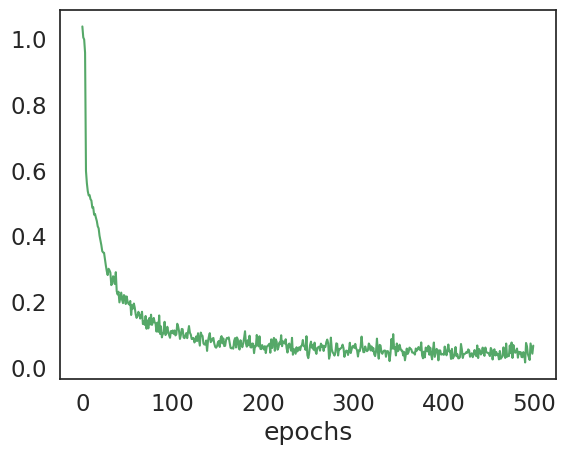

In [14]:
df.ssl_loss.plot(c = 'g')

<Axes: xlabel='epochs'>

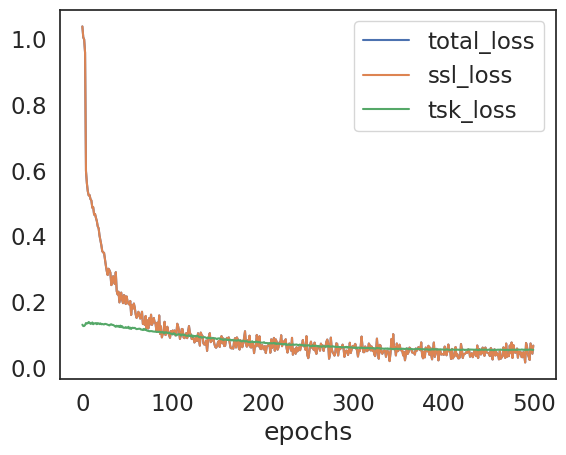

In [10]:
df.plot()

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


UMAP(random_state=42, spread=5, verbose=1)
Sun Oct 15 20:26:36 2023 Construct fuzzy simplicial set
Sun Oct 15 20:26:36 2023 Finding Nearest Neighbors
Sun Oct 15 20:26:36 2023 Building RP forest with 10 trees
Sun Oct 15 20:26:36 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sun Oct 15 20:26:37 2023 Finished Nearest Neighbor Search
Sun Oct 15 20:26:37 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Oct 15 20:26:47 2023 Finished embedding


/tmp/ipykernel_31561/3960265566.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']


UMAP(random_state=42, spread=5, verbose=1)
Sun Oct 15 20:26:51 2023 Construct fuzzy simplicial set
Sun Oct 15 20:26:51 2023 Finding Nearest Neighbors
Sun Oct 15 20:26:51 2023 Finished Nearest Neighbor Search
Sun Oct 15 20:26:51 2023 Construct embedding


/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 15 20:26:52 2023 Finished embedding


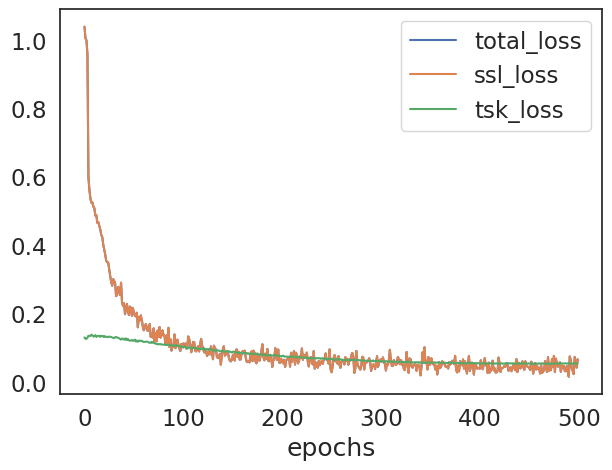

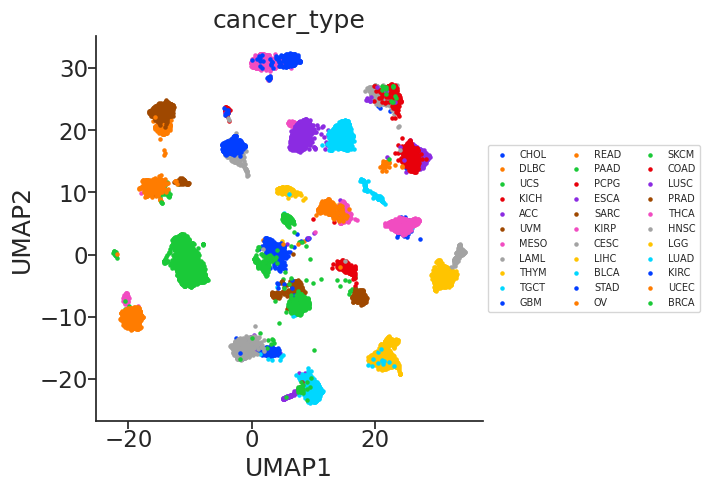

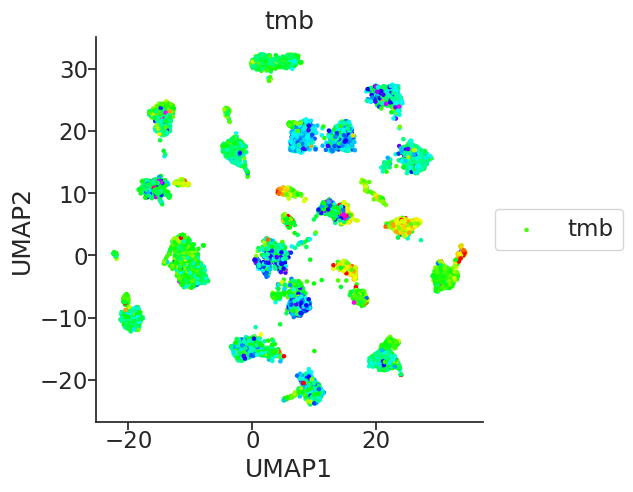

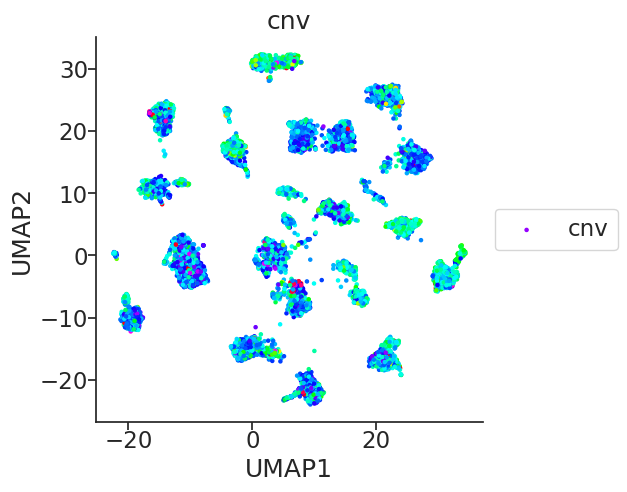

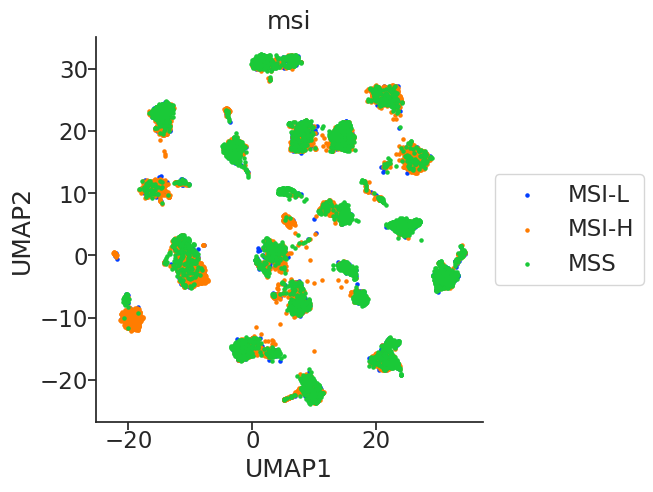

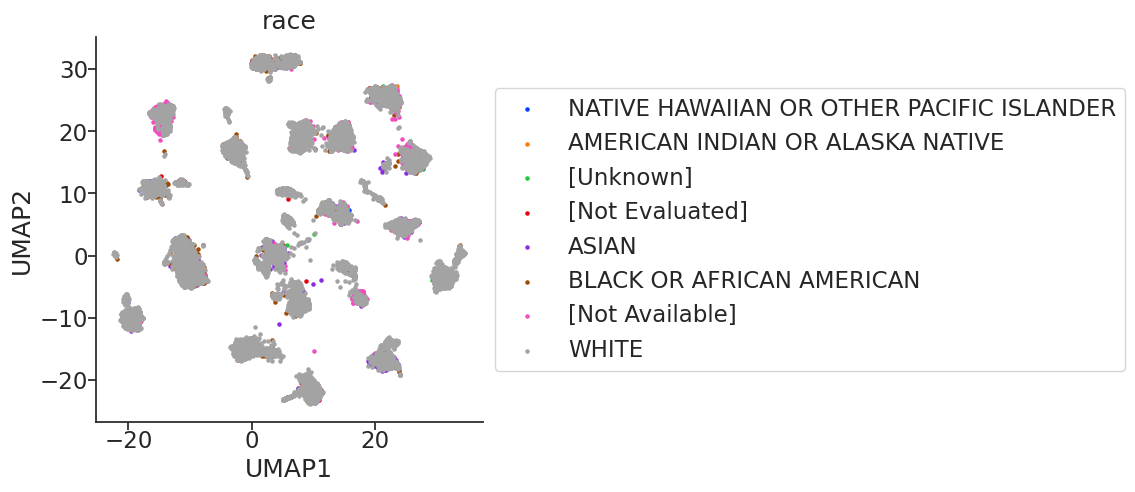

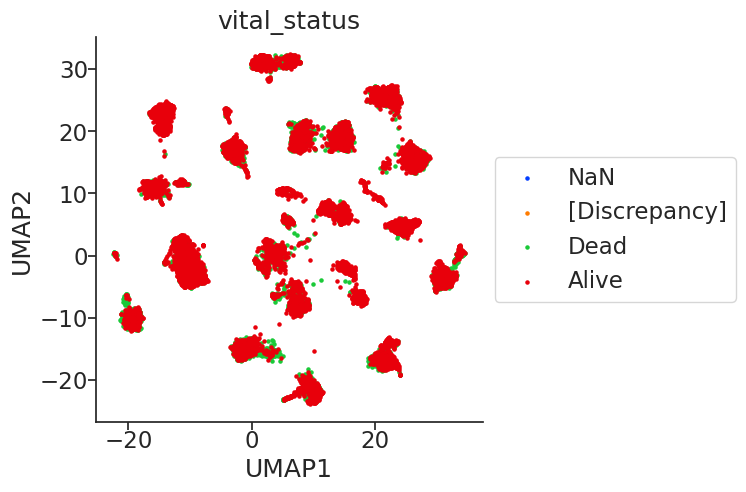

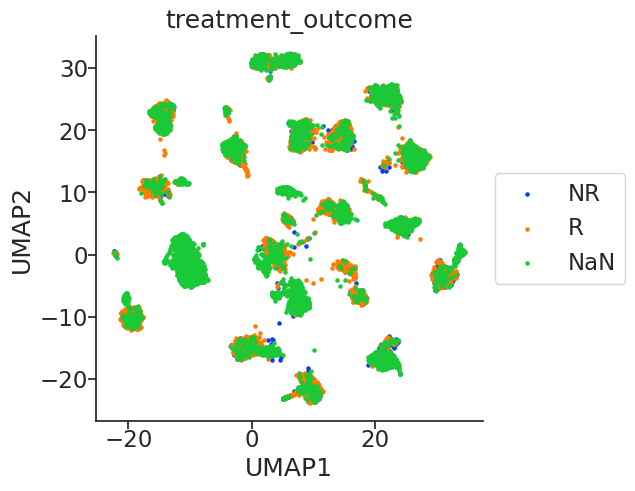

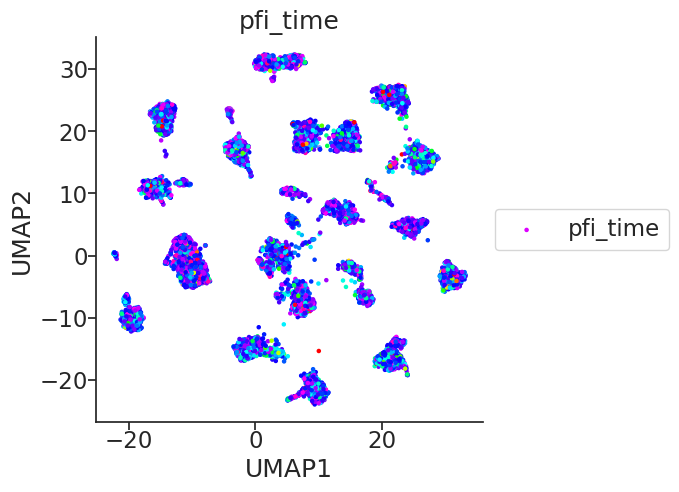

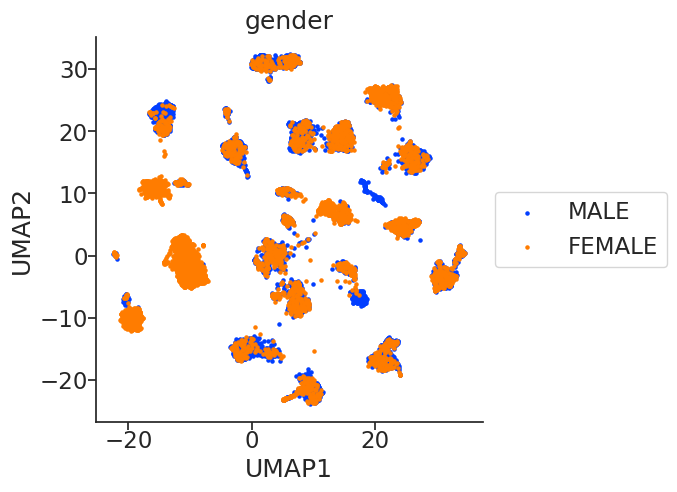

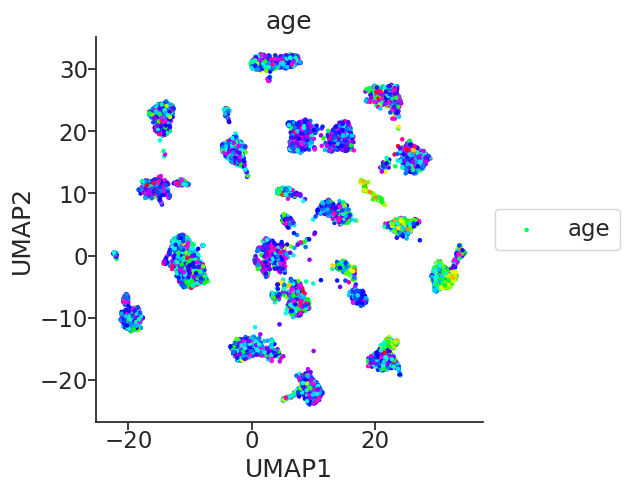

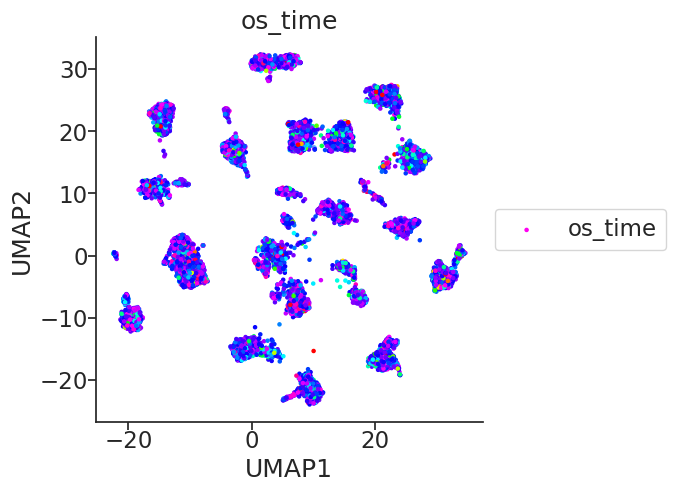

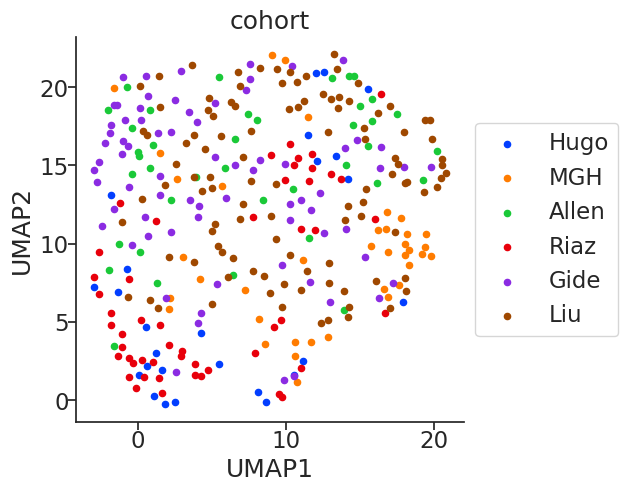

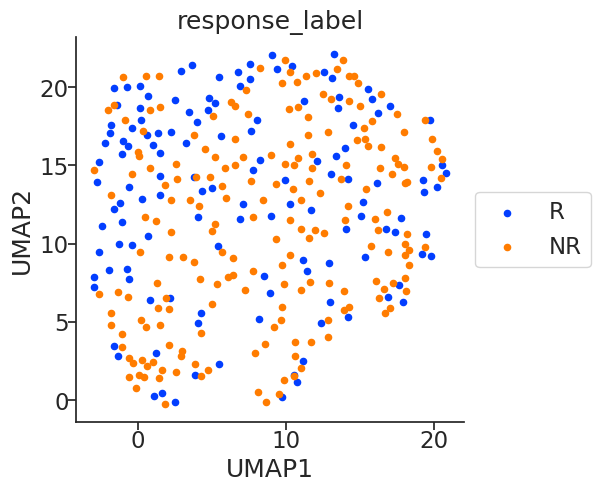

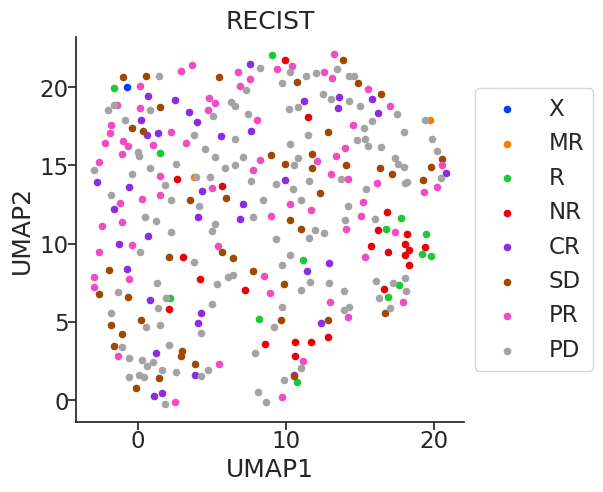

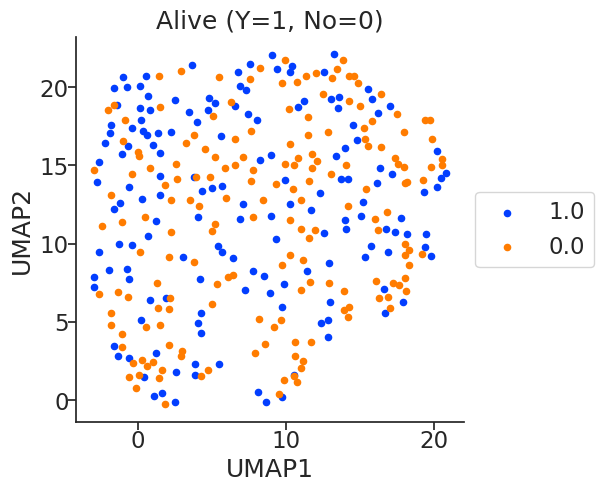

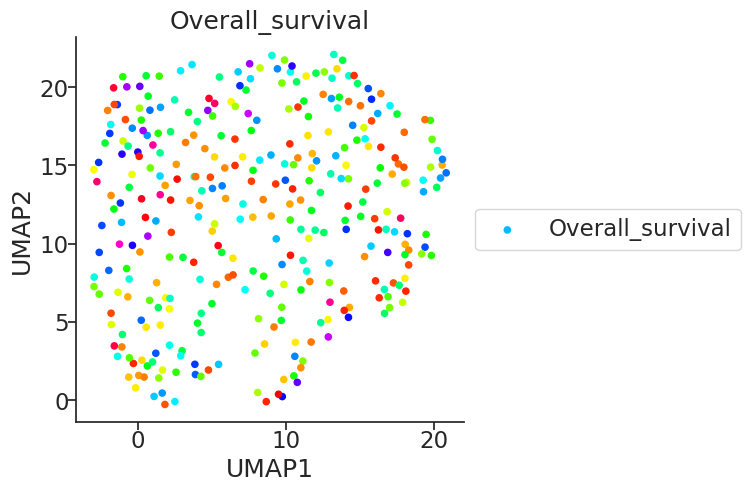

In [11]:


    ## plot loss
    df = pd.DataFrame(performace, columns = ['epochs', 'total_loss', 'ssl_loss', 'tsk_loss']).set_index('epochs')
    v = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    fig, ax = plt.subplots(figsize=(7,5))
    df.plot(ax = ax)
    fig.savefig(os.path.join(save_dir, 'tcga_train_loss.png'), bbox_inches='tight')
    df.to_pickle(os.path.join(save_dir, 'tcga_train_loss.pkl'))

    ### make prediction & plot on TCGA
    model = TCGAPretrainModel(**saver.inMemorySave['model_args']) #transformer_dim = 128, transformer_num_layers = 2
    model.load_state_dict(saver.inMemorySave['model_state_dict'])
    dfe, dfp = predict(df_tpm, model,  device='cpu')
    dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
    msi = tcga_label[['msi']]
    cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')
    
    l1 = tcga_label[['race', 'vital_status', 'treatment_outcome']].fillna('NaN')
    l2 = np.log10(tcga_label[['pfi_time', 'os_time']]+1)
    l3 = tcga_label[['gender', 'age',]]


    dfd = dfe.join(dfc).join(df_tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)
    
    label_col = ['cancer_type', 'tmb', 'cnv', 'msi','race', 'vital_status', 
                 'treatment_outcome','pfi_time', 'gender', 'age', 'os_time']
    label_type = ['c', 'r', 'r', 'c',  'c', 'c', 'c',  'r',  'c', 'r', 'r',]
    figs = plot_embed_with_label(dfd, n_neighbors=15, spread=5,
                                 label_col = label_col,  
                                 label_type = label_type, figsize=(5,5))
    
    for fig, name in zip(figs, label_col):
        fig.savefig(os.path.join(save_dir, 'tcga_%s.png' % name), bbox_inches='tight', )

    ### make prediction & plot on ITRP
    itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
    itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
    itrp_meta['response_label'] = itrp_meta['Freeman_response']
    itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']
    itrp_y = itrp_meta[['response_label']]
    itrp_c = itrp_meta[['cohort']]
    itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T
    
    itrp_dfe, itrp_dfp = predict(itrp_x, model,  device='cpu')

    label_col = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
    label_type = ['c', 'c', 'c', 'c', 'r']
    dfd = itrp_dfe.join(itrp_meta[label_col])
    figs = plot_embed_with_label(dfd, n_neighbors=15,
                                spread=5,
                                s=20,
                                 label_col = label_col,  
                                 label_type = label_type, figsize=(5,5))
    for fig, name in zip(figs, label_col):
        fig.savefig(os.path.join(save_dir, 'itrp_%s.png' % name), bbox_inches='tight', )